# GAN AE Discriminator

### Imports:

In [2]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LeakyReLU
from keras import regularizers
from keras.constraints import UnitNorm, MaxNorm

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


***
## Hyperparameters & Options

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
n_train = 25000
scaler = Normalizer()

### OPTIONS ###
savePlots = True
plotsLocation = "./"

### GAN ###
n_epochs = 1000
batch_size = 265
ascent_fraction = 0.1
leak = 0.5

    # Discriminator (AE)
encoding_dim = 3
encoder_activation = 'tanh'
decoder_activation = 'tanh'
ae_activations = 'linear'
ae_constraint = None

    ## Generator
noise_dim = 7
generator_activation = 'tanh'
hidden_activations = 'linear'
g_constraint = None

***
### Load Data & Preprocessing

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
coordinate_change(sig_all)
coordinate_change(bkg_all)

if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
f_s = n_train/n_sig
f_b = n_train/n_bkg

print ("Number of BACKGROUND events:", n_bkg)
print ("%0.2f%% = %d" % (f_b*100, n_train), "used for TRAINING")
print ("%.2f%% = %d" % (f_b*100, n_train), "used for TESTING")
print ("%05.2f%% = %d" % ((1-2*f_b)*100, n_bkg - 2*n_train), "unused")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_train), "used for TESTING")
print ("%.2f%% = %d" % ((1-f_s)*100, n_sig - n_train), "unused")
print ("\n")

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:2*n_train], sig_sel.iloc[:n_train]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13) 
train_time = 0
n_cycle = 0

Number of BACKGROUND events: 54194
46.13% = 25000 used for TRAINING
46.13% = 25000 used for TESTING
07.74% = 4194 unused
Number of SIGNAL events: 52766
47.38% = 25000 used for TESTING
52.62% = 27766 unused


Training sample size:  (25000, 13)
Testing sample size:  (50000, 13)


### Discriminator (Deep AE)

In [4]:
hidden_activation = 'linear'
encoder_activation = 'tanh'
decoder_activation = 'tanh'
#constraint = UnitNorm(axis=0)
#constraint = MaxNorm(max_value=3, axis=0)
#constraint = None

# Encoder Layers
encoder_in = Input(shape=(input_dim,), name='enc_in')
encoder_1 = Dense(20, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h1')(encoder_in)
activate_e1 = LeakyReLU(alpha=leak)(encoder_1)
encoder_2 = Dense(17, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h2')(activate_e1)
activate_e2 = LeakyReLU(alpha=leak)(encoder_2)
encoder_3 = Dense(14, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h3')(activate_e2)
activate_e3 = LeakyReLU(alpha=leak)(encoder_3)
encoder_4 = Dense(12, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h4')(activate_e3)
activate_e4 = LeakyReLU(alpha=leak)(encoder_4)
encoder_5 = Dense(10, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h5')(activate_e4)
activate_e5 = LeakyReLU(alpha=leak)(encoder_5)
encoder_6 = Dense(7, activation=ae_activations, kernel_constraint=ae_constraint, name='enc_h6')(activate_e5)
activate_e6 = LeakyReLU(alpha=leak)(encoder_6)
encoder_out = Dense(encoding_dim, activation=encoder_activation, kernel_constraint=ae_constraint, name='enc_out')(activate_e6)

# Decoder Layers
decoder_1 = Dense(7, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h1')(encoder_out)
activate_d1 = LeakyReLU(alpha=leak)(decoder_1)
decoder_2 = Dense(10, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h2')(activate_d1)
activate_d2 = LeakyReLU(alpha=leak)(decoder_2)
decoder_3 = Dense(12, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h3')(activate_d2)
activate_d3 = LeakyReLU(alpha=leak)(decoder_3)
decoder_4 = Dense(14, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h4')(activate_d3)
activate_d4 = LeakyReLU(alpha=leak)(decoder_4)
decoder_5 = Dense(17, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h5')(activate_d4)
activate_d5 = LeakyReLU(alpha=leak)(decoder_5)
decoder_6 = Dense(20, activation=ae_activations, kernel_constraint=ae_constraint, name='dec_h6')(activate_d5)
activate_d6 = LeakyReLU(alpha=leak)(decoder_6)
decoder_out = Dense(input_dim, activation=decoder_activation, kernel_constraint=ae_constraint, name='dec_out')(activate_d6)
  
autoencoder = Model(encoder_in, decoder_out)
encoder = Model(encoder_in, decoder_out)
    
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
print(autoencoder.layers[26])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_in (InputLayer)          (None, 13)                0         
_________________________________________________________________
enc_h1 (Dense)               (None, 20)                280       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
enc_h2 (Dense)               (None, 17)                357       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 17)                0         
_________________________________________________________________
enc_h3 (Dense)               (None, 14)                252       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14)                0         
__________

### Generator

In [5]:
generator = Sequential()
generator.add(Dense(10, kernel_constraint=g_constraint, input_shape=(noise_dim,), activation=hidden_activations, name='generator_hidden_1'))
generator.add(LeakyReLU(alpha=leak))
generator.add(Dense(15, kernel_constraint=g_constraint, activation=hidden_activations, name='generator_hidden_2'))
generator.add(LeakyReLU(alpha=leak))
generator.add(Dense(20, kernel_constraint=g_constraint, activation=hidden_activations, name='generator_hidden_3'))
generator.add(LeakyReLU(alpha=leak))
generator.add(Dense(15, kernel_constraint=g_constraint, activation=hidden_activations, name='generator_hidden_4'))
generator.add(LeakyReLU(alpha=leak))
generator.add(Dense(input_dim, kernel_constraint=g_constraint, activation=generator_activation, name='generator_output'))


generator.summary()
generator.compile(optimizer='adam', loss='binary_crossentropy')
print(generator.layers[8])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_hidden_1 (Dense)   (None, 10)                140       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 15)                165       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 15)                0         
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 20)                320       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
generator_hidden_4 (Dense)   (None, 15)                315       
__________

### Adversarial Model

In [6]:
input_img_adv = Input(shape=(input_dim,))
AM = Sequential()
output_img_gen = generator.layers[8](generator.layers[7](generator.layers[6](generator.layers[5](
                generator.layers[4](generator.layers[3](generator.layers[2](generator.layers[1](
                generator.layers[0](input_img_adv)))))))))
output_img_adv = autoencoder.layers[26](autoencoder.layers[25](autoencoder.layers[24](autoencoder.layers[23](
                autoencoder.layers[22](autoencoder.layers[21](autoencoder.layers[20](autoencoder.layers[19](
                autoencoder.layers[18](autoencoder.layers[17](autoencoder.layers[16](autoencoder.layers[15](
                autoencoder.layers[14](autoencoder.layers[13](autoencoder.layers[12](autoencoder.layers[11](
                autoencoder.layers[10](autoencoder.layers[9](autoencoder.layers[8](autoencoder.layers[7](
                autoencoder.layers[6](autoencoder.layers[5](autoencoder.layers[4](autoencoder.layers[3](
                autoencoder.layers[2](autoencoder.layers[1](
                    autoencoder.layers[0](output_img_gen)))))))))))))))))))))))))))

AM = Model(input_img_adv, output_img_adv)

AM.get_layer('enc_h1').trainable = False
AM.get_layer('enc_h2').trainable = False
AM.get_layer('enc_h3').trainable = False
AM.get_layer('enc_h4').trainable = False
AM.get_layer('enc_h5').trainable = False
AM.get_layer('enc_h6').trainable = False
AM.get_layer('enc_out').trainable = False
AM.get_layer('dec_h1').trainable = False
AM.get_layer('dec_h2').trainable = False
AM.get_layer('dec_h3').trainable = False
AM.get_layer('dec_h4').trainable = False
AM.get_layer('dec_h5').trainable = False
AM.get_layer('dec_h6').trainable = False
AM.get_layer('dec_out').trainable = False


AM.compile(loss='mse', optimizer='adam')

AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
generator_hidden_1 (Dense)   (None, 10)                140       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
generator_hidden_2 (Dense)   (None, 15)                165       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 15)                0         
_________________________________________________________________
generator_hidden_3 (Dense)   (None, 20)                320       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 20)                0         
__________

### Training

In [9]:
discriminator_history = np.empty([n_epochs,2])
adversarial_history = []

gradient_ascent=-ascent_fraction*np.ones(batch_size)


start = time.time()

with tf.device('/GPU:0'):
    for i in range(n_epochs):
        
            #discriminator
            data_train = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            noise = np.random.uniform(0, 1.0, size=[batch_size, noise_dim])
            data_fake = generator.predict(noise)
            d_loss_data = autoencoder.train_on_batch(data_train, data_train)
            
            ### USE THIS FOR GRADIENT ASCENT ###
            d_loss_fake = autoencoder.train_on_batch(data_fake, data_fake, sample_weight = gradient_ascent)
            ###
            
            discriminator_history[i]=[d_loss_data, d_loss_fake]
            
            #AM 
            noise = np.random.uniform(0, 1.0, size=[batch_size, noise_dim])
            y = generator.predict(noise)
            a_loss = AM.train_on_batch(noise, y)
            adversarial_history.append(a_loss)
            prc = ((i+1)/n_epochs)*100
            log_mesg = "%.2f%% [D loss Real: %f, D loss Fake: %f]" % (prc, d_loss_data, d_loss_fake)
            log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
            print(log_mesg)

end = time.time()
train_time += (end-start)
n_cycle += 1

/home/ioan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0.02% [D loss Real: 0.076478, D loss Fake: -0.001416]  [A loss: 0.072049]
0.04% [D loss Real: 0.074118, D loss Fake: -0.001395]  [A loss: 0.073374]
0.06% [D loss Real: 0.071573, D loss Fake: -0.001440]  [A loss: 0.077775]
0.08% [D loss Real: 0.068961, D loss Fake: -0.001606]  [A loss: 0.080061]
0.10% [D loss Real: 0.066048, D loss Fake: -0.001799]  [A loss: 0.091244]
0.12% [D loss Real: 0.063019, D loss Fake: -0.001938]  [A loss: 0.097516]
0.14% [D loss Real: 0.059423, D loss Fake: -0.002066]  [A loss: 0.105105]
0.16% [D loss Real: 0.055961, D loss Fake: -0.002389]  [A loss: 0.123390]
0.18% [D loss Real: 0.051939, D loss Fake: -0.002643]  [A loss: 0.134742]
0.20% [D loss Real: 0.047598, D loss Fake: -0.002995]  [A loss: 0.142805]
0.22% [D loss Real: 0.043649, D loss Fake: -0.003180]  [A loss: 0.162436]
0.24% [D loss Real: 0.039790, D loss Fake: -0.003509]  [A loss: 0.177651]
0.26% [D loss Real: 0.035924, D loss Fake: -0.003810]  [A loss: 0.196085]
0.28% [D loss Real: 0.032306, D loss F

2.36% [D loss Real: 0.008096, D loss Fake: -0.003478]  [A loss: 0.175881]
2.38% [D loss Real: 0.008423, D loss Fake: -0.003586]  [A loss: 0.180679]
2.40% [D loss Real: 0.008082, D loss Fake: -0.003561]  [A loss: 0.179370]
2.42% [D loss Real: 0.009045, D loss Fake: -0.003584]  [A loss: 0.178996]
2.44% [D loss Real: 0.008991, D loss Fake: -0.003577]  [A loss: 0.176106]
2.46% [D loss Real: 0.008371, D loss Fake: -0.003459]  [A loss: 0.176382]
2.48% [D loss Real: 0.009155, D loss Fake: -0.003534]  [A loss: 0.175883]
2.50% [D loss Real: 0.009153, D loss Fake: -0.003421]  [A loss: 0.171577]
2.52% [D loss Real: 0.008107, D loss Fake: -0.003294]  [A loss: 0.163301]
2.54% [D loss Real: 0.009323, D loss Fake: -0.003207]  [A loss: 0.162630]
2.56% [D loss Real: 0.008189, D loss Fake: -0.003153]  [A loss: 0.163465]
2.58% [D loss Real: 0.007916, D loss Fake: -0.003068]  [A loss: 0.157290]
2.60% [D loss Real: 0.008343, D loss Fake: -0.002971]  [A loss: 0.152309]
2.62% [D loss Real: 0.007613, D loss F

4.68% [D loss Real: 0.002840, D loss Fake: -0.002889]  [A loss: 0.155339]
4.70% [D loss Real: 0.002714, D loss Fake: -0.002809]  [A loss: 0.152551]
4.72% [D loss Real: 0.002585, D loss Fake: -0.002962]  [A loss: 0.155295]
4.74% [D loss Real: 0.002676, D loss Fake: -0.003084]  [A loss: 0.156218]
4.76% [D loss Real: 0.002502, D loss Fake: -0.003086]  [A loss: 0.160717]
4.78% [D loss Real: 0.002952, D loss Fake: -0.003125]  [A loss: 0.166788]
4.80% [D loss Real: 0.002505, D loss Fake: -0.003187]  [A loss: 0.175490]
4.82% [D loss Real: 0.002482, D loss Fake: -0.003357]  [A loss: 0.176824]
4.84% [D loss Real: 0.002261, D loss Fake: -0.003312]  [A loss: 0.170336]
4.86% [D loss Real: 0.002744, D loss Fake: -0.003387]  [A loss: 0.191517]
4.88% [D loss Real: 0.003230, D loss Fake: -0.003270]  [A loss: 0.167238]
4.90% [D loss Real: 0.005315, D loss Fake: -0.003444]  [A loss: 0.195259]
4.92% [D loss Real: 0.007210, D loss Fake: -0.003368]  [A loss: 0.176421]
4.94% [D loss Real: 0.004784, D loss F

6.92% [D loss Real: 0.001339, D loss Fake: -0.001939]  [A loss: 0.095795]
6.94% [D loss Real: 0.001126, D loss Fake: -0.002010]  [A loss: 0.101636]
6.96% [D loss Real: 0.001324, D loss Fake: -0.002102]  [A loss: 0.106108]
6.98% [D loss Real: 0.001314, D loss Fake: -0.002167]  [A loss: 0.108689]
7.00% [D loss Real: 0.001205, D loss Fake: -0.002192]  [A loss: 0.110104]
7.02% [D loss Real: 0.001164, D loss Fake: -0.002235]  [A loss: 0.114842]
7.04% [D loss Real: 0.001080, D loss Fake: -0.002326]  [A loss: 0.118812]
7.06% [D loss Real: 0.001204, D loss Fake: -0.002356]  [A loss: 0.120932]
7.08% [D loss Real: 0.001055, D loss Fake: -0.002377]  [A loss: 0.120547]
7.10% [D loss Real: 0.001236, D loss Fake: -0.002450]  [A loss: 0.123801]
7.12% [D loss Real: 0.001108, D loss Fake: -0.002458]  [A loss: 0.129243]
7.14% [D loss Real: 0.001195, D loss Fake: -0.002552]  [A loss: 0.129282]
7.16% [D loss Real: 0.000983, D loss Fake: -0.002597]  [A loss: 0.131999]
7.18% [D loss Real: 0.000989, D loss F

9.16% [D loss Real: 0.001143, D loss Fake: -0.002850]  [A loss: 0.145863]
9.18% [D loss Real: 0.001222, D loss Fake: -0.002929]  [A loss: 0.149136]
9.20% [D loss Real: 0.001109, D loss Fake: -0.002945]  [A loss: 0.149409]
9.22% [D loss Real: 0.001188, D loss Fake: -0.002979]  [A loss: 0.151379]
9.24% [D loss Real: 0.001104, D loss Fake: -0.002990]  [A loss: 0.155512]
9.26% [D loss Real: 0.001100, D loss Fake: -0.002997]  [A loss: 0.155837]
9.28% [D loss Real: 0.001087, D loss Fake: -0.003015]  [A loss: 0.153683]
9.30% [D loss Real: 0.001338, D loss Fake: -0.002908]  [A loss: 0.148882]
9.32% [D loss Real: 0.001234, D loss Fake: -0.002861]  [A loss: 0.148469]
9.34% [D loss Real: 0.001014, D loss Fake: -0.002853]  [A loss: 0.143467]
9.36% [D loss Real: 0.001282, D loss Fake: -0.002661]  [A loss: 0.139176]
9.38% [D loss Real: 0.001111, D loss Fake: -0.002674]  [A loss: 0.131504]
9.40% [D loss Real: 0.001213, D loss Fake: -0.002594]  [A loss: 0.132866]
9.42% [D loss Real: 0.001300, D loss F

11.50% [D loss Real: 0.005345, D loss Fake: -0.000710]  [A loss: 0.036235]
11.52% [D loss Real: 0.005383, D loss Fake: -0.000869]  [A loss: 0.040339]
11.54% [D loss Real: 0.004897, D loss Fake: -0.000844]  [A loss: 0.045695]
11.56% [D loss Real: 0.004342, D loss Fake: -0.000866]  [A loss: 0.039625]
11.58% [D loss Real: 0.003443, D loss Fake: -0.000782]  [A loss: 0.041381]
11.60% [D loss Real: 0.003425, D loss Fake: -0.000730]  [A loss: 0.034254]
11.62% [D loss Real: 0.003061, D loss Fake: -0.000665]  [A loss: 0.036095]
11.64% [D loss Real: 0.002914, D loss Fake: -0.000692]  [A loss: 0.035324]
11.66% [D loss Real: 0.002786, D loss Fake: -0.000676]  [A loss: 0.033171]
11.68% [D loss Real: 0.002869, D loss Fake: -0.000641]  [A loss: 0.031384]
11.70% [D loss Real: 0.002549, D loss Fake: -0.000606]  [A loss: 0.032198]
11.72% [D loss Real: 0.002514, D loss Fake: -0.000617]  [A loss: 0.030266]
11.74% [D loss Real: 0.002337, D loss Fake: -0.000585]  [A loss: 0.030469]
11.76% [D loss Real: 0.00

13.78% [D loss Real: 0.001075, D loss Fake: -0.000239]  [A loss: 0.011885]
13.80% [D loss Real: 0.001213, D loss Fake: -0.000239]  [A loss: 0.011988]
13.82% [D loss Real: 0.001111, D loss Fake: -0.000247]  [A loss: 0.012021]
13.84% [D loss Real: 0.001007, D loss Fake: -0.000248]  [A loss: 0.012059]
13.86% [D loss Real: 0.001001, D loss Fake: -0.000260]  [A loss: 0.011882]
13.88% [D loss Real: 0.000998, D loss Fake: -0.000236]  [A loss: 0.012579]
13.90% [D loss Real: 0.000933, D loss Fake: -0.000242]  [A loss: 0.011482]
13.92% [D loss Real: 0.000896, D loss Fake: -0.000244]  [A loss: 0.012078]
13.94% [D loss Real: 0.000971, D loss Fake: -0.000244]  [A loss: 0.011821]
13.96% [D loss Real: 0.001041, D loss Fake: -0.000225]  [A loss: 0.011631]
13.98% [D loss Real: 0.001034, D loss Fake: -0.000234]  [A loss: 0.011898]
14.00% [D loss Real: 0.001062, D loss Fake: -0.000234]  [A loss: 0.011663]
14.02% [D loss Real: 0.001059, D loss Fake: -0.000235]  [A loss: 0.010992]
14.04% [D loss Real: 0.00

16.04% [D loss Real: 0.000722, D loss Fake: -0.000183]  [A loss: 0.009258]
16.06% [D loss Real: 0.000952, D loss Fake: -0.000190]  [A loss: 0.009518]
16.08% [D loss Real: 0.000747, D loss Fake: -0.000185]  [A loss: 0.009095]
16.10% [D loss Real: 0.000811, D loss Fake: -0.000186]  [A loss: 0.009356]
16.12% [D loss Real: 0.000848, D loss Fake: -0.000188]  [A loss: 0.009220]
16.14% [D loss Real: 0.000831, D loss Fake: -0.000182]  [A loss: 0.009530]
16.16% [D loss Real: 0.000898, D loss Fake: -0.000181]  [A loss: 0.009755]
16.18% [D loss Real: 0.000924, D loss Fake: -0.000182]  [A loss: 0.009128]
16.20% [D loss Real: 0.000758, D loss Fake: -0.000184]  [A loss: 0.009265]
16.22% [D loss Real: 0.000862, D loss Fake: -0.000185]  [A loss: 0.009109]
16.24% [D loss Real: 0.000825, D loss Fake: -0.000188]  [A loss: 0.008933]
16.26% [D loss Real: 0.000798, D loss Fake: -0.000196]  [A loss: 0.008995]
16.28% [D loss Real: 0.000814, D loss Fake: -0.000181]  [A loss: 0.009215]
16.30% [D loss Real: 0.00

18.32% [D loss Real: 0.000757, D loss Fake: -0.000173]  [A loss: 0.008537]
18.34% [D loss Real: 0.000718, D loss Fake: -0.000163]  [A loss: 0.008614]
18.36% [D loss Real: 0.000762, D loss Fake: -0.000169]  [A loss: 0.008580]
18.38% [D loss Real: 0.000744, D loss Fake: -0.000172]  [A loss: 0.008326]
18.40% [D loss Real: 0.000879, D loss Fake: -0.000167]  [A loss: 0.008164]
18.42% [D loss Real: 0.000708, D loss Fake: -0.000166]  [A loss: 0.008489]
18.44% [D loss Real: 0.000690, D loss Fake: -0.000172]  [A loss: 0.008587]
18.46% [D loss Real: 0.000792, D loss Fake: -0.000168]  [A loss: 0.008659]
18.48% [D loss Real: 0.000823, D loss Fake: -0.000168]  [A loss: 0.008545]
18.50% [D loss Real: 0.000718, D loss Fake: -0.000181]  [A loss: 0.008729]
18.52% [D loss Real: 0.000776, D loss Fake: -0.000177]  [A loss: 0.008536]
18.54% [D loss Real: 0.000753, D loss Fake: -0.000166]  [A loss: 0.008499]
18.56% [D loss Real: 0.000760, D loss Fake: -0.000173]  [A loss: 0.008463]
18.58% [D loss Real: 0.00

20.64% [D loss Real: 0.000630, D loss Fake: -0.000165]  [A loss: 0.008157]
20.66% [D loss Real: 0.000671, D loss Fake: -0.000157]  [A loss: 0.008001]
20.68% [D loss Real: 0.000683, D loss Fake: -0.000162]  [A loss: 0.008161]
20.70% [D loss Real: 0.000666, D loss Fake: -0.000158]  [A loss: 0.007993]
20.72% [D loss Real: 0.000644, D loss Fake: -0.000164]  [A loss: 0.008016]
20.74% [D loss Real: 0.000562, D loss Fake: -0.000168]  [A loss: 0.008208]
20.76% [D loss Real: 0.000636, D loss Fake: -0.000158]  [A loss: 0.008287]
20.78% [D loss Real: 0.000590, D loss Fake: -0.000165]  [A loss: 0.008245]
20.80% [D loss Real: 0.000710, D loss Fake: -0.000159]  [A loss: 0.008019]
20.82% [D loss Real: 0.000686, D loss Fake: -0.000164]  [A loss: 0.008147]
20.84% [D loss Real: 0.000695, D loss Fake: -0.000165]  [A loss: 0.007972]
20.86% [D loss Real: 0.000623, D loss Fake: -0.000162]  [A loss: 0.007991]
20.88% [D loss Real: 0.000707, D loss Fake: -0.000160]  [A loss: 0.007920]
20.90% [D loss Real: 0.00

23.06% [D loss Real: 0.000560, D loss Fake: -0.000155]  [A loss: 0.007850]
23.08% [D loss Real: 0.000721, D loss Fake: -0.000160]  [A loss: 0.007925]
23.10% [D loss Real: 0.000636, D loss Fake: -0.000159]  [A loss: 0.007805]
23.12% [D loss Real: 0.000592, D loss Fake: -0.000158]  [A loss: 0.008130]
23.14% [D loss Real: 0.000651, D loss Fake: -0.000159]  [A loss: 0.007793]
23.16% [D loss Real: 0.000570, D loss Fake: -0.000160]  [A loss: 0.007830]
23.18% [D loss Real: 0.000610, D loss Fake: -0.000160]  [A loss: 0.008104]
23.20% [D loss Real: 0.000589, D loss Fake: -0.000163]  [A loss: 0.008182]
23.22% [D loss Real: 0.000630, D loss Fake: -0.000160]  [A loss: 0.008067]
23.24% [D loss Real: 0.000583, D loss Fake: -0.000160]  [A loss: 0.008063]
23.26% [D loss Real: 0.000675, D loss Fake: -0.000160]  [A loss: 0.008239]
23.28% [D loss Real: 0.000661, D loss Fake: -0.000160]  [A loss: 0.007863]
23.30% [D loss Real: 0.000761, D loss Fake: -0.000153]  [A loss: 0.007542]
23.32% [D loss Real: 0.00

25.26% [D loss Real: 0.000563, D loss Fake: -0.000162]  [A loss: 0.008120]
25.28% [D loss Real: 0.000553, D loss Fake: -0.000160]  [A loss: 0.007929]
25.30% [D loss Real: 0.000585, D loss Fake: -0.000160]  [A loss: 0.007801]
25.32% [D loss Real: 0.000599, D loss Fake: -0.000153]  [A loss: 0.008010]
25.34% [D loss Real: 0.000615, D loss Fake: -0.000156]  [A loss: 0.007762]
25.36% [D loss Real: 0.000556, D loss Fake: -0.000160]  [A loss: 0.007913]
25.38% [D loss Real: 0.000598, D loss Fake: -0.000158]  [A loss: 0.008098]
25.40% [D loss Real: 0.000526, D loss Fake: -0.000162]  [A loss: 0.008118]
25.42% [D loss Real: 0.000505, D loss Fake: -0.000164]  [A loss: 0.008057]
25.44% [D loss Real: 0.000631, D loss Fake: -0.000161]  [A loss: 0.008152]
25.46% [D loss Real: 0.000566, D loss Fake: -0.000159]  [A loss: 0.007911]
25.48% [D loss Real: 0.000594, D loss Fake: -0.000155]  [A loss: 0.007631]
25.50% [D loss Real: 0.000679, D loss Fake: -0.000153]  [A loss: 0.007981]
25.52% [D loss Real: 0.00

27.68% [D loss Real: 0.000400, D loss Fake: -0.000165]  [A loss: 0.007997]
27.70% [D loss Real: 0.000598, D loss Fake: -0.000162]  [A loss: 0.008155]
27.72% [D loss Real: 0.000482, D loss Fake: -0.000163]  [A loss: 0.008110]
27.74% [D loss Real: 0.000571, D loss Fake: -0.000166]  [A loss: 0.008278]
27.76% [D loss Real: 0.000455, D loss Fake: -0.000162]  [A loss: 0.008016]
27.78% [D loss Real: 0.000471, D loss Fake: -0.000161]  [A loss: 0.008189]
27.80% [D loss Real: 0.000498, D loss Fake: -0.000159]  [A loss: 0.008135]
27.82% [D loss Real: 0.000492, D loss Fake: -0.000159]  [A loss: 0.007822]
27.84% [D loss Real: 0.000447, D loss Fake: -0.000162]  [A loss: 0.008201]
27.86% [D loss Real: 0.000528, D loss Fake: -0.000162]  [A loss: 0.008167]
27.88% [D loss Real: 0.000491, D loss Fake: -0.000161]  [A loss: 0.008148]
27.90% [D loss Real: 0.000521, D loss Fake: -0.000161]  [A loss: 0.008163]
27.92% [D loss Real: 0.000454, D loss Fake: -0.000160]  [A loss: 0.008112]
27.94% [D loss Real: 0.00

30.06% [D loss Real: 0.000416, D loss Fake: -0.000169]  [A loss: 0.008206]
30.08% [D loss Real: 0.000396, D loss Fake: -0.000173]  [A loss: 0.008507]
30.10% [D loss Real: 0.000423, D loss Fake: -0.000171]  [A loss: 0.008461]
30.12% [D loss Real: 0.000418, D loss Fake: -0.000168]  [A loss: 0.008774]
30.14% [D loss Real: 0.000461, D loss Fake: -0.000169]  [A loss: 0.008510]
30.16% [D loss Real: 0.000379, D loss Fake: -0.000167]  [A loss: 0.008438]
30.18% [D loss Real: 0.000440, D loss Fake: -0.000167]  [A loss: 0.008388]
30.20% [D loss Real: 0.000369, D loss Fake: -0.000171]  [A loss: 0.008417]
30.22% [D loss Real: 0.000436, D loss Fake: -0.000165]  [A loss: 0.008246]
30.24% [D loss Real: 0.000422, D loss Fake: -0.000165]  [A loss: 0.008413]
30.26% [D loss Real: 0.000393, D loss Fake: -0.000165]  [A loss: 0.008323]
30.28% [D loss Real: 0.000364, D loss Fake: -0.000169]  [A loss: 0.008486]
30.30% [D loss Real: 0.000390, D loss Fake: -0.000165]  [A loss: 0.008466]
30.32% [D loss Real: 0.00

32.46% [D loss Real: 0.000355, D loss Fake: -0.000177]  [A loss: 0.008617]
32.48% [D loss Real: 0.000314, D loss Fake: -0.000169]  [A loss: 0.008914]
32.50% [D loss Real: 0.000326, D loss Fake: -0.000175]  [A loss: 0.008946]
32.52% [D loss Real: 0.000368, D loss Fake: -0.000175]  [A loss: 0.008592]
32.54% [D loss Real: 0.000337, D loss Fake: -0.000173]  [A loss: 0.008920]
32.56% [D loss Real: 0.000349, D loss Fake: -0.000177]  [A loss: 0.008742]
32.58% [D loss Real: 0.000346, D loss Fake: -0.000177]  [A loss: 0.008602]
32.60% [D loss Real: 0.000337, D loss Fake: -0.000175]  [A loss: 0.008733]
32.62% [D loss Real: 0.000317, D loss Fake: -0.000174]  [A loss: 0.008803]
32.64% [D loss Real: 0.000351, D loss Fake: -0.000175]  [A loss: 0.008920]
32.66% [D loss Real: 0.000303, D loss Fake: -0.000176]  [A loss: 0.008908]
32.68% [D loss Real: 0.000335, D loss Fake: -0.000176]  [A loss: 0.009021]
32.70% [D loss Real: 0.000368, D loss Fake: -0.000180]  [A loss: 0.009106]
32.72% [D loss Real: 0.00

34.86% [D loss Real: 0.000235, D loss Fake: -0.000191]  [A loss: 0.009467]
34.88% [D loss Real: 0.000255, D loss Fake: -0.000191]  [A loss: 0.009346]
34.90% [D loss Real: 0.000264, D loss Fake: -0.000190]  [A loss: 0.009447]
34.92% [D loss Real: 0.000270, D loss Fake: -0.000189]  [A loss: 0.009624]
34.94% [D loss Real: 0.000258, D loss Fake: -0.000192]  [A loss: 0.009815]
34.96% [D loss Real: 0.000276, D loss Fake: -0.000193]  [A loss: 0.009747]
34.98% [D loss Real: 0.000269, D loss Fake: -0.000197]  [A loss: 0.009842]
35.00% [D loss Real: 0.000255, D loss Fake: -0.000194]  [A loss: 0.010015]
35.02% [D loss Real: 0.000255, D loss Fake: -0.000197]  [A loss: 0.009899]
35.04% [D loss Real: 0.000278, D loss Fake: -0.000197]  [A loss: 0.009522]
35.06% [D loss Real: 0.000243, D loss Fake: -0.000189]  [A loss: 0.009729]
35.08% [D loss Real: 0.000276, D loss Fake: -0.000197]  [A loss: 0.009911]
35.10% [D loss Real: 0.000251, D loss Fake: -0.000195]  [A loss: 0.009752]
35.12% [D loss Real: 0.00

37.28% [D loss Real: 0.000220, D loss Fake: -0.000222]  [A loss: 0.011049]
37.30% [D loss Real: 0.000227, D loss Fake: -0.000222]  [A loss: 0.010686]
37.32% [D loss Real: 0.000213, D loss Fake: -0.000212]  [A loss: 0.010974]
37.34% [D loss Real: 0.000219, D loss Fake: -0.000218]  [A loss: 0.010850]
37.36% [D loss Real: 0.000195, D loss Fake: -0.000218]  [A loss: 0.010950]
37.38% [D loss Real: 0.000237, D loss Fake: -0.000218]  [A loss: 0.010986]
37.40% [D loss Real: 0.000247, D loss Fake: -0.000218]  [A loss: 0.010848]
37.42% [D loss Real: 0.000211, D loss Fake: -0.000217]  [A loss: 0.010815]
37.44% [D loss Real: 0.000230, D loss Fake: -0.000222]  [A loss: 0.011011]
37.46% [D loss Real: 0.000231, D loss Fake: -0.000222]  [A loss: 0.010957]
37.48% [D loss Real: 0.000209, D loss Fake: -0.000225]  [A loss: 0.011259]
37.50% [D loss Real: 0.000223, D loss Fake: -0.000224]  [A loss: 0.010869]
37.52% [D loss Real: 0.000215, D loss Fake: -0.000221]  [A loss: 0.010813]
37.54% [D loss Real: 0.00

39.68% [D loss Real: 0.000214, D loss Fake: -0.000259]  [A loss: 0.012846]
39.70% [D loss Real: 0.000234, D loss Fake: -0.000261]  [A loss: 0.012600]
39.72% [D loss Real: 0.000183, D loss Fake: -0.000259]  [A loss: 0.013508]
39.74% [D loss Real: 0.000196, D loss Fake: -0.000258]  [A loss: 0.013162]
39.76% [D loss Real: 0.000193, D loss Fake: -0.000258]  [A loss: 0.013007]
39.78% [D loss Real: 0.000218, D loss Fake: -0.000254]  [A loss: 0.013295]
39.80% [D loss Real: 0.000210, D loss Fake: -0.000259]  [A loss: 0.013213]
39.82% [D loss Real: 0.000199, D loss Fake: -0.000262]  [A loss: 0.012838]
39.84% [D loss Real: 0.000199, D loss Fake: -0.000262]  [A loss: 0.012965]
39.86% [D loss Real: 0.000208, D loss Fake: -0.000267]  [A loss: 0.013528]
39.88% [D loss Real: 0.000187, D loss Fake: -0.000264]  [A loss: 0.012975]
39.90% [D loss Real: 0.000205, D loss Fake: -0.000255]  [A loss: 0.012974]
39.92% [D loss Real: 0.000193, D loss Fake: -0.000258]  [A loss: 0.012993]
39.94% [D loss Real: 0.00

42.06% [D loss Real: 0.000177, D loss Fake: -0.000216]  [A loss: 0.011013]
42.08% [D loss Real: 0.000197, D loss Fake: -0.000211]  [A loss: 0.010596]
42.10% [D loss Real: 0.000215, D loss Fake: -0.000214]  [A loss: 0.010848]
42.12% [D loss Real: 0.000180, D loss Fake: -0.000210]  [A loss: 0.010982]
42.14% [D loss Real: 0.000200, D loss Fake: -0.000213]  [A loss: 0.010795]
42.16% [D loss Real: 0.000185, D loss Fake: -0.000217]  [A loss: 0.010731]
42.18% [D loss Real: 0.000202, D loss Fake: -0.000210]  [A loss: 0.010790]
42.20% [D loss Real: 0.000175, D loss Fake: -0.000214]  [A loss: 0.010690]
42.22% [D loss Real: 0.000200, D loss Fake: -0.000214]  [A loss: 0.010900]
42.24% [D loss Real: 0.000177, D loss Fake: -0.000209]  [A loss: 0.010773]
42.26% [D loss Real: 0.000175, D loss Fake: -0.000214]  [A loss: 0.010630]
42.28% [D loss Real: 0.000189, D loss Fake: -0.000208]  [A loss: 0.010624]
42.30% [D loss Real: 0.000190, D loss Fake: -0.000213]  [A loss: 0.010756]
42.32% [D loss Real: 0.00

44.44% [D loss Real: 0.000191, D loss Fake: -0.000191]  [A loss: 0.009225]
44.46% [D loss Real: 0.000194, D loss Fake: -0.000191]  [A loss: 0.009470]
44.48% [D loss Real: 0.000169, D loss Fake: -0.000184]  [A loss: 0.009382]
44.50% [D loss Real: 0.000181, D loss Fake: -0.000182]  [A loss: 0.009269]
44.52% [D loss Real: 0.000175, D loss Fake: -0.000185]  [A loss: 0.009280]
44.54% [D loss Real: 0.000186, D loss Fake: -0.000189]  [A loss: 0.009489]
44.56% [D loss Real: 0.000190, D loss Fake: -0.000187]  [A loss: 0.009248]
44.58% [D loss Real: 0.000197, D loss Fake: -0.000182]  [A loss: 0.009463]
44.60% [D loss Real: 0.000182, D loss Fake: -0.000186]  [A loss: 0.009368]
44.62% [D loss Real: 0.000193, D loss Fake: -0.000186]  [A loss: 0.009235]
44.64% [D loss Real: 0.000184, D loss Fake: -0.000188]  [A loss: 0.009379]
44.66% [D loss Real: 0.000162, D loss Fake: -0.000189]  [A loss: 0.009651]
44.68% [D loss Real: 0.000171, D loss Fake: -0.000191]  [A loss: 0.009426]
44.70% [D loss Real: 0.00

46.78% [D loss Real: 0.000177, D loss Fake: -0.000168]  [A loss: 0.008599]
46.80% [D loss Real: 0.000178, D loss Fake: -0.000172]  [A loss: 0.008763]
46.82% [D loss Real: 0.000188, D loss Fake: -0.000175]  [A loss: 0.008708]
46.84% [D loss Real: 0.000188, D loss Fake: -0.000170]  [A loss: 0.008518]
46.86% [D loss Real: 0.000188, D loss Fake: -0.000169]  [A loss: 0.008794]
46.88% [D loss Real: 0.000195, D loss Fake: -0.000172]  [A loss: 0.008696]
46.90% [D loss Real: 0.000194, D loss Fake: -0.000170]  [A loss: 0.008495]
46.92% [D loss Real: 0.000166, D loss Fake: -0.000170]  [A loss: 0.008611]
46.94% [D loss Real: 0.000193, D loss Fake: -0.000169]  [A loss: 0.008622]
46.96% [D loss Real: 0.000179, D loss Fake: -0.000170]  [A loss: 0.008423]
46.98% [D loss Real: 0.000161, D loss Fake: -0.000169]  [A loss: 0.008684]
47.00% [D loss Real: 0.000193, D loss Fake: -0.000170]  [A loss: 0.008424]
47.02% [D loss Real: 0.000176, D loss Fake: -0.000169]  [A loss: 0.008411]
47.04% [D loss Real: 0.00

49.16% [D loss Real: 0.000173, D loss Fake: -0.000162]  [A loss: 0.007953]
49.18% [D loss Real: 0.000141, D loss Fake: -0.000162]  [A loss: 0.008042]
49.20% [D loss Real: 0.000148, D loss Fake: -0.000163]  [A loss: 0.008067]
49.22% [D loss Real: 0.000154, D loss Fake: -0.000161]  [A loss: 0.008197]
49.24% [D loss Real: 0.000170, D loss Fake: -0.000163]  [A loss: 0.008261]
49.26% [D loss Real: 0.000174, D loss Fake: -0.000163]  [A loss: 0.008219]
49.28% [D loss Real: 0.000185, D loss Fake: -0.000162]  [A loss: 0.008184]
49.30% [D loss Real: 0.000165, D loss Fake: -0.000165]  [A loss: 0.008148]
49.32% [D loss Real: 0.000176, D loss Fake: -0.000165]  [A loss: 0.008196]
49.34% [D loss Real: 0.000179, D loss Fake: -0.000161]  [A loss: 0.008159]
49.36% [D loss Real: 0.000167, D loss Fake: -0.000161]  [A loss: 0.008143]
49.38% [D loss Real: 0.000158, D loss Fake: -0.000161]  [A loss: 0.008194]
49.40% [D loss Real: 0.000179, D loss Fake: -0.000162]  [A loss: 0.008137]
49.42% [D loss Real: 0.00

51.58% [D loss Real: 0.000160, D loss Fake: -0.000162]  [A loss: 0.008159]
51.60% [D loss Real: 0.000169, D loss Fake: -0.000159]  [A loss: 0.007954]
51.62% [D loss Real: 0.000166, D loss Fake: -0.000161]  [A loss: 0.008056]
51.64% [D loss Real: 0.000159, D loss Fake: -0.000159]  [A loss: 0.007923]
51.66% [D loss Real: 0.000166, D loss Fake: -0.000158]  [A loss: 0.008196]
51.68% [D loss Real: 0.000159, D loss Fake: -0.000161]  [A loss: 0.008198]
51.70% [D loss Real: 0.000185, D loss Fake: -0.000161]  [A loss: 0.008089]
51.72% [D loss Real: 0.000167, D loss Fake: -0.000161]  [A loss: 0.008140]
51.74% [D loss Real: 0.000196, D loss Fake: -0.000161]  [A loss: 0.007948]
51.76% [D loss Real: 0.000156, D loss Fake: -0.000161]  [A loss: 0.008040]
51.78% [D loss Real: 0.000176, D loss Fake: -0.000157]  [A loss: 0.008132]
51.80% [D loss Real: 0.000155, D loss Fake: -0.000162]  [A loss: 0.008189]
51.82% [D loss Real: 0.000142, D loss Fake: -0.000164]  [A loss: 0.008212]
51.84% [D loss Real: 0.00

53.98% [D loss Real: 0.000166, D loss Fake: -0.000161]  [A loss: 0.008173]
54.00% [D loss Real: 0.000171, D loss Fake: -0.000158]  [A loss: 0.008110]
54.02% [D loss Real: 0.000146, D loss Fake: -0.000163]  [A loss: 0.008105]
54.04% [D loss Real: 0.000165, D loss Fake: -0.000165]  [A loss: 0.008268]
54.06% [D loss Real: 0.000155, D loss Fake: -0.000163]  [A loss: 0.008230]
54.08% [D loss Real: 0.000160, D loss Fake: -0.000166]  [A loss: 0.008452]
54.10% [D loss Real: 0.000164, D loss Fake: -0.000164]  [A loss: 0.008296]
54.12% [D loss Real: 0.000173, D loss Fake: -0.000162]  [A loss: 0.008252]
54.14% [D loss Real: 0.000212, D loss Fake: -0.000160]  [A loss: 0.008093]
54.16% [D loss Real: 0.000158, D loss Fake: -0.000160]  [A loss: 0.008133]
54.18% [D loss Real: 0.000153, D loss Fake: -0.000162]  [A loss: 0.008121]
54.20% [D loss Real: 0.000169, D loss Fake: -0.000165]  [A loss: 0.008455]
54.22% [D loss Real: 0.000176, D loss Fake: -0.000164]  [A loss: 0.008482]
54.24% [D loss Real: 0.00

56.32% [D loss Real: 0.000187, D loss Fake: -0.000173]  [A loss: 0.008899]
56.34% [D loss Real: 0.000158, D loss Fake: -0.000175]  [A loss: 0.008660]
56.36% [D loss Real: 0.000184, D loss Fake: -0.000177]  [A loss: 0.008961]
56.38% [D loss Real: 0.000156, D loss Fake: -0.000175]  [A loss: 0.008726]
56.40% [D loss Real: 0.000167, D loss Fake: -0.000171]  [A loss: 0.008619]
56.42% [D loss Real: 0.000170, D loss Fake: -0.000172]  [A loss: 0.008706]
56.44% [D loss Real: 0.000166, D loss Fake: -0.000172]  [A loss: 0.008836]
56.46% [D loss Real: 0.000148, D loss Fake: -0.000176]  [A loss: 0.008654]
56.48% [D loss Real: 0.000152, D loss Fake: -0.000174]  [A loss: 0.009041]
56.50% [D loss Real: 0.000149, D loss Fake: -0.000176]  [A loss: 0.008891]
56.52% [D loss Real: 0.000153, D loss Fake: -0.000176]  [A loss: 0.008831]
56.54% [D loss Real: 0.000148, D loss Fake: -0.000175]  [A loss: 0.008722]
56.56% [D loss Real: 0.000163, D loss Fake: -0.000174]  [A loss: 0.008603]
56.58% [D loss Real: 0.00

58.66% [D loss Real: 0.000176, D loss Fake: -0.000194]  [A loss: 0.009781]
58.68% [D loss Real: 0.000165, D loss Fake: -0.000194]  [A loss: 0.009903]
58.70% [D loss Real: 0.000192, D loss Fake: -0.000195]  [A loss: 0.009745]
58.72% [D loss Real: 0.000151, D loss Fake: -0.000200]  [A loss: 0.009944]
58.74% [D loss Real: 0.000166, D loss Fake: -0.000200]  [A loss: 0.009712]
58.76% [D loss Real: 0.000139, D loss Fake: -0.000204]  [A loss: 0.010050]
58.78% [D loss Real: 0.000185, D loss Fake: -0.000198]  [A loss: 0.010043]
58.80% [D loss Real: 0.000173, D loss Fake: -0.000199]  [A loss: 0.010145]
58.82% [D loss Real: 0.000151, D loss Fake: -0.000200]  [A loss: 0.010117]
58.84% [D loss Real: 0.000147, D loss Fake: -0.000199]  [A loss: 0.009972]
58.86% [D loss Real: 0.000152, D loss Fake: -0.000200]  [A loss: 0.009957]
58.88% [D loss Real: 0.000143, D loss Fake: -0.000196]  [A loss: 0.009962]
58.90% [D loss Real: 0.000153, D loss Fake: -0.000200]  [A loss: 0.009998]
58.92% [D loss Real: 0.00

61.00% [D loss Real: 0.000183, D loss Fake: -0.000303]  [A loss: 0.016021]
61.02% [D loss Real: 0.000174, D loss Fake: -0.000319]  [A loss: 0.016206]
61.04% [D loss Real: 0.000188, D loss Fake: -0.000321]  [A loss: 0.016167]
61.06% [D loss Real: 0.000197, D loss Fake: -0.000328]  [A loss: 0.017020]
61.08% [D loss Real: 0.000181, D loss Fake: -0.000331]  [A loss: 0.016887]
61.10% [D loss Real: 0.000166, D loss Fake: -0.000341]  [A loss: 0.017270]
61.12% [D loss Real: 0.000173, D loss Fake: -0.000337]  [A loss: 0.017442]
61.14% [D loss Real: 0.000150, D loss Fake: -0.000344]  [A loss: 0.017928]
61.16% [D loss Real: 0.000178, D loss Fake: -0.000354]  [A loss: 0.018454]
61.18% [D loss Real: 0.000183, D loss Fake: -0.000359]  [A loss: 0.018205]
61.20% [D loss Real: 0.000191, D loss Fake: -0.000355]  [A loss: 0.018620]
61.22% [D loss Real: 0.000165, D loss Fake: -0.000387]  [A loss: 0.019561]
61.24% [D loss Real: 0.000185, D loss Fake: -0.000384]  [A loss: 0.020545]
61.26% [D loss Real: 0.00

63.36% [D loss Real: 0.000260, D loss Fake: -0.000338]  [A loss: 0.016839]
63.38% [D loss Real: 0.000273, D loss Fake: -0.000327]  [A loss: 0.017333]
63.40% [D loss Real: 0.000246, D loss Fake: -0.000320]  [A loss: 0.016799]
63.42% [D loss Real: 0.000238, D loss Fake: -0.000303]  [A loss: 0.014766]
63.44% [D loss Real: 0.000254, D loss Fake: -0.000282]  [A loss: 0.014550]
63.46% [D loss Real: 0.000237, D loss Fake: -0.000289]  [A loss: 0.013895]
63.48% [D loss Real: 0.000240, D loss Fake: -0.000259]  [A loss: 0.013283]
63.50% [D loss Real: 0.000243, D loss Fake: -0.000264]  [A loss: 0.013452]
63.52% [D loss Real: 0.000209, D loss Fake: -0.000262]  [A loss: 0.013092]
63.54% [D loss Real: 0.000251, D loss Fake: -0.000261]  [A loss: 0.013454]
63.56% [D loss Real: 0.000225, D loss Fake: -0.000271]  [A loss: 0.013132]
63.58% [D loss Real: 0.000218, D loss Fake: -0.000274]  [A loss: 0.013261]
63.60% [D loss Real: 0.000270, D loss Fake: -0.000273]  [A loss: 0.013420]
63.62% [D loss Real: 0.00

65.80% [D loss Real: 0.000199, D loss Fake: -0.000266]  [A loss: 0.013465]
65.82% [D loss Real: 0.000195, D loss Fake: -0.000264]  [A loss: 0.013453]
65.84% [D loss Real: 0.000206, D loss Fake: -0.000262]  [A loss: 0.013478]
65.86% [D loss Real: 0.000190, D loss Fake: -0.000265]  [A loss: 0.013252]
65.88% [D loss Real: 0.000190, D loss Fake: -0.000264]  [A loss: 0.013410]
65.90% [D loss Real: 0.000196, D loss Fake: -0.000271]  [A loss: 0.013594]
65.92% [D loss Real: 0.000193, D loss Fake: -0.000271]  [A loss: 0.013587]
65.94% [D loss Real: 0.000187, D loss Fake: -0.000274]  [A loss: 0.013798]
65.96% [D loss Real: 0.000193, D loss Fake: -0.000274]  [A loss: 0.013584]
65.98% [D loss Real: 0.000215, D loss Fake: -0.000271]  [A loss: 0.013571]
66.00% [D loss Real: 0.000184, D loss Fake: -0.000272]  [A loss: 0.013753]
66.02% [D loss Real: 0.000217, D loss Fake: -0.000276]  [A loss: 0.014012]
66.04% [D loss Real: 0.000187, D loss Fake: -0.000274]  [A loss: 0.013876]
66.06% [D loss Real: 0.00

68.12% [D loss Real: 0.000200, D loss Fake: -0.000396]  [A loss: 0.020072]
68.14% [D loss Real: 0.000206, D loss Fake: -0.000406]  [A loss: 0.020525]
68.16% [D loss Real: 0.000240, D loss Fake: -0.000409]  [A loss: 0.020625]
68.18% [D loss Real: 0.000222, D loss Fake: -0.000407]  [A loss: 0.020292]
68.20% [D loss Real: 0.000209, D loss Fake: -0.000400]  [A loss: 0.020091]
68.22% [D loss Real: 0.000233, D loss Fake: -0.000400]  [A loss: 0.019972]
68.24% [D loss Real: 0.000211, D loss Fake: -0.000401]  [A loss: 0.020263]
68.26% [D loss Real: 0.000212, D loss Fake: -0.000401]  [A loss: 0.020219]
68.28% [D loss Real: 0.000233, D loss Fake: -0.000408]  [A loss: 0.020390]
68.30% [D loss Real: 0.000249, D loss Fake: -0.000408]  [A loss: 0.020649]
68.32% [D loss Real: 0.000235, D loss Fake: -0.000408]  [A loss: 0.020611]
68.34% [D loss Real: 0.000226, D loss Fake: -0.000403]  [A loss: 0.020375]
68.36% [D loss Real: 0.000274, D loss Fake: -0.000403]  [A loss: 0.020236]
68.38% [D loss Real: 0.00

70.38% [D loss Real: 0.000278, D loss Fake: -0.000459]  [A loss: 0.023510]
70.40% [D loss Real: 0.000231, D loss Fake: -0.000459]  [A loss: 0.023261]
70.42% [D loss Real: 0.000207, D loss Fake: -0.000461]  [A loss: 0.023524]
70.44% [D loss Real: 0.000248, D loss Fake: -0.000463]  [A loss: 0.023482]
70.46% [D loss Real: 0.000227, D loss Fake: -0.000466]  [A loss: 0.023823]
70.48% [D loss Real: 0.000261, D loss Fake: -0.000461]  [A loss: 0.023445]
70.50% [D loss Real: 0.000248, D loss Fake: -0.000463]  [A loss: 0.023824]
70.52% [D loss Real: 0.000274, D loss Fake: -0.000470]  [A loss: 0.023410]
70.54% [D loss Real: 0.000238, D loss Fake: -0.000472]  [A loss: 0.023355]
70.56% [D loss Real: 0.000232, D loss Fake: -0.000466]  [A loss: 0.023598]
70.58% [D loss Real: 0.000280, D loss Fake: -0.000466]  [A loss: 0.023700]
70.60% [D loss Real: 0.000235, D loss Fake: -0.000471]  [A loss: 0.023472]
70.62% [D loss Real: 0.000269, D loss Fake: -0.000464]  [A loss: 0.023794]
70.64% [D loss Real: 0.00

72.76% [D loss Real: 0.000201, D loss Fake: -0.000222]  [A loss: 0.011192]
72.78% [D loss Real: 0.000164, D loss Fake: -0.000220]  [A loss: 0.011509]
72.80% [D loss Real: 0.000190, D loss Fake: -0.000223]  [A loss: 0.011071]
72.82% [D loss Real: 0.000167, D loss Fake: -0.000224]  [A loss: 0.011185]
72.84% [D loss Real: 0.000172, D loss Fake: -0.000221]  [A loss: 0.011181]
72.86% [D loss Real: 0.000194, D loss Fake: -0.000218]  [A loss: 0.011157]
72.88% [D loss Real: 0.000162, D loss Fake: -0.000222]  [A loss: 0.011244]
72.90% [D loss Real: 0.000199, D loss Fake: -0.000223]  [A loss: 0.011405]
72.92% [D loss Real: 0.000208, D loss Fake: -0.000223]  [A loss: 0.011176]
72.94% [D loss Real: 0.000188, D loss Fake: -0.000217]  [A loss: 0.011122]
72.96% [D loss Real: 0.000181, D loss Fake: -0.000221]  [A loss: 0.011142]
72.98% [D loss Real: 0.000163, D loss Fake: -0.000223]  [A loss: 0.011027]
73.00% [D loss Real: 0.000192, D loss Fake: -0.000218]  [A loss: 0.011084]
73.02% [D loss Real: 0.00

75.14% [D loss Real: 0.000152, D loss Fake: -0.000219]  [A loss: 0.010870]
75.16% [D loss Real: 0.000184, D loss Fake: -0.000220]  [A loss: 0.010920]
75.18% [D loss Real: 0.000179, D loss Fake: -0.000225]  [A loss: 0.010899]
75.20% [D loss Real: 0.000164, D loss Fake: -0.000218]  [A loss: 0.010760]
75.22% [D loss Real: 0.000161, D loss Fake: -0.000216]  [A loss: 0.010960]
75.24% [D loss Real: 0.000186, D loss Fake: -0.000218]  [A loss: 0.010895]
75.26% [D loss Real: 0.000166, D loss Fake: -0.000216]  [A loss: 0.010935]
75.28% [D loss Real: 0.000161, D loss Fake: -0.000215]  [A loss: 0.010891]
75.30% [D loss Real: 0.000179, D loss Fake: -0.000212]  [A loss: 0.010676]
75.32% [D loss Real: 0.000162, D loss Fake: -0.000216]  [A loss: 0.010768]
75.34% [D loss Real: 0.000160, D loss Fake: -0.000219]  [A loss: 0.010813]
75.36% [D loss Real: 0.000175, D loss Fake: -0.000217]  [A loss: 0.010741]
75.38% [D loss Real: 0.000157, D loss Fake: -0.000212]  [A loss: 0.010824]
75.40% [D loss Real: 0.00

77.52% [D loss Real: 0.000165, D loss Fake: -0.000218]  [A loss: 0.010942]
77.54% [D loss Real: 0.000160, D loss Fake: -0.000218]  [A loss: 0.010825]
77.56% [D loss Real: 0.000158, D loss Fake: -0.000221]  [A loss: 0.011113]
77.58% [D loss Real: 0.000177, D loss Fake: -0.000218]  [A loss: 0.011038]
77.60% [D loss Real: 0.000167, D loss Fake: -0.000220]  [A loss: 0.011110]
77.62% [D loss Real: 0.000179, D loss Fake: -0.000217]  [A loss: 0.011015]
77.64% [D loss Real: 0.000179, D loss Fake: -0.000215]  [A loss: 0.010937]
77.66% [D loss Real: 0.000164, D loss Fake: -0.000217]  [A loss: 0.011057]
77.68% [D loss Real: 0.000162, D loss Fake: -0.000217]  [A loss: 0.010857]
77.70% [D loss Real: 0.000167, D loss Fake: -0.000215]  [A loss: 0.010923]
77.72% [D loss Real: 0.000142, D loss Fake: -0.000220]  [A loss: 0.011219]
77.74% [D loss Real: 0.000177, D loss Fake: -0.000218]  [A loss: 0.011053]
77.76% [D loss Real: 0.000181, D loss Fake: -0.000223]  [A loss: 0.010949]
77.78% [D loss Real: 0.00

79.86% [D loss Real: 0.000179, D loss Fake: -0.000221]  [A loss: 0.011143]
79.88% [D loss Real: 0.000144, D loss Fake: -0.000218]  [A loss: 0.011243]
79.90% [D loss Real: 0.000156, D loss Fake: -0.000218]  [A loss: 0.011040]
79.92% [D loss Real: 0.000170, D loss Fake: -0.000224]  [A loss: 0.011102]
79.94% [D loss Real: 0.000193, D loss Fake: -0.000221]  [A loss: 0.011154]
79.96% [D loss Real: 0.000165, D loss Fake: -0.000216]  [A loss: 0.011057]
79.98% [D loss Real: 0.000169, D loss Fake: -0.000219]  [A loss: 0.011282]
80.00% [D loss Real: 0.000171, D loss Fake: -0.000224]  [A loss: 0.010943]
80.02% [D loss Real: 0.000142, D loss Fake: -0.000218]  [A loss: 0.010954]
80.04% [D loss Real: 0.000155, D loss Fake: -0.000217]  [A loss: 0.011176]
80.06% [D loss Real: 0.000159, D loss Fake: -0.000220]  [A loss: 0.011179]
80.08% [D loss Real: 0.000163, D loss Fake: -0.000220]  [A loss: 0.011287]
80.10% [D loss Real: 0.000174, D loss Fake: -0.000223]  [A loss: 0.011476]
80.12% [D loss Real: 0.00

82.22% [D loss Real: 0.000156, D loss Fake: -0.000223]  [A loss: 0.011232]
82.24% [D loss Real: 0.000177, D loss Fake: -0.000220]  [A loss: 0.011250]
82.26% [D loss Real: 0.000161, D loss Fake: -0.000222]  [A loss: 0.011217]
82.28% [D loss Real: 0.000186, D loss Fake: -0.000221]  [A loss: 0.011343]
82.30% [D loss Real: 0.000153, D loss Fake: -0.000224]  [A loss: 0.011351]
82.32% [D loss Real: 0.000165, D loss Fake: -0.000223]  [A loss: 0.011010]
82.34% [D loss Real: 0.000203, D loss Fake: -0.000219]  [A loss: 0.010980]
82.36% [D loss Real: 0.000149, D loss Fake: -0.000223]  [A loss: 0.010996]
82.38% [D loss Real: 0.000151, D loss Fake: -0.000224]  [A loss: 0.011158]
82.40% [D loss Real: 0.000148, D loss Fake: -0.000220]  [A loss: 0.010779]
82.42% [D loss Real: 0.000159, D loss Fake: -0.000217]  [A loss: 0.011141]
82.44% [D loss Real: 0.000173, D loss Fake: -0.000223]  [A loss: 0.011227]
82.46% [D loss Real: 0.000160, D loss Fake: -0.000226]  [A loss: 0.011319]
82.48% [D loss Real: 0.00

84.58% [D loss Real: 0.000163, D loss Fake: -0.000211]  [A loss: 0.010910]
84.60% [D loss Real: 0.000154, D loss Fake: -0.000213]  [A loss: 0.010841]
84.62% [D loss Real: 0.000152, D loss Fake: -0.000213]  [A loss: 0.010749]
84.64% [D loss Real: 0.000200, D loss Fake: -0.000214]  [A loss: 0.010982]
84.66% [D loss Real: 0.000154, D loss Fake: -0.000213]  [A loss: 0.010547]
84.68% [D loss Real: 0.000162, D loss Fake: -0.000214]  [A loss: 0.010697]
84.70% [D loss Real: 0.000171, D loss Fake: -0.000215]  [A loss: 0.010727]
84.72% [D loss Real: 0.000153, D loss Fake: -0.000215]  [A loss: 0.010880]
84.74% [D loss Real: 0.000162, D loss Fake: -0.000214]  [A loss: 0.011130]
84.76% [D loss Real: 0.000221, D loss Fake: -0.000215]  [A loss: 0.010420]
84.78% [D loss Real: 0.000220, D loss Fake: -0.000213]  [A loss: 0.010818]
84.80% [D loss Real: 0.000198, D loss Fake: -0.000209]  [A loss: 0.010714]
84.82% [D loss Real: 0.000188, D loss Fake: -0.000221]  [A loss: 0.011137]
84.84% [D loss Real: 0.00

86.92% [D loss Real: 0.000163, D loss Fake: -0.000218]  [A loss: 0.010926]
86.94% [D loss Real: 0.000145, D loss Fake: -0.000218]  [A loss: 0.011258]
86.96% [D loss Real: 0.000198, D loss Fake: -0.000225]  [A loss: 0.011200]
86.98% [D loss Real: 0.000164, D loss Fake: -0.000223]  [A loss: 0.011232]
87.00% [D loss Real: 0.000172, D loss Fake: -0.000224]  [A loss: 0.010823]
87.02% [D loss Real: 0.000187, D loss Fake: -0.000217]  [A loss: 0.010881]
87.04% [D loss Real: 0.000155, D loss Fake: -0.000215]  [A loss: 0.011057]
87.06% [D loss Real: 0.000151, D loss Fake: -0.000222]  [A loss: 0.011146]
87.08% [D loss Real: 0.000154, D loss Fake: -0.000222]  [A loss: 0.011111]
87.10% [D loss Real: 0.000155, D loss Fake: -0.000216]  [A loss: 0.011147]
87.12% [D loss Real: 0.000174, D loss Fake: -0.000215]  [A loss: 0.010943]
87.14% [D loss Real: 0.000162, D loss Fake: -0.000218]  [A loss: 0.011157]
87.16% [D loss Real: 0.000172, D loss Fake: -0.000222]  [A loss: 0.011232]
87.18% [D loss Real: 0.00

89.32% [D loss Real: 0.000139, D loss Fake: -0.000246]  [A loss: 0.012801]
89.34% [D loss Real: 0.000166, D loss Fake: -0.000250]  [A loss: 0.012641]
89.36% [D loss Real: 0.000188, D loss Fake: -0.000247]  [A loss: 0.012551]
89.38% [D loss Real: 0.000193, D loss Fake: -0.000243]  [A loss: 0.012139]
89.40% [D loss Real: 0.000157, D loss Fake: -0.000243]  [A loss: 0.012269]
89.42% [D loss Real: 0.000170, D loss Fake: -0.000250]  [A loss: 0.012516]
89.44% [D loss Real: 0.000209, D loss Fake: -0.000254]  [A loss: 0.012393]
89.46% [D loss Real: 0.000208, D loss Fake: -0.000246]  [A loss: 0.012641]
89.48% [D loss Real: 0.000201, D loss Fake: -0.000246]  [A loss: 0.012506]
89.50% [D loss Real: 0.000165, D loss Fake: -0.000244]  [A loss: 0.012505]
89.52% [D loss Real: 0.000171, D loss Fake: -0.000253]  [A loss: 0.012351]
89.54% [D loss Real: 0.000151, D loss Fake: -0.000252]  [A loss: 0.012451]
89.56% [D loss Real: 0.000140, D loss Fake: -0.000251]  [A loss: 0.012579]
89.58% [D loss Real: 0.00

91.68% [D loss Real: 0.000163, D loss Fake: -0.000323]  [A loss: 0.015987]
91.70% [D loss Real: 0.000182, D loss Fake: -0.000325]  [A loss: 0.015653]
91.72% [D loss Real: 0.000147, D loss Fake: -0.000323]  [A loss: 0.016207]
91.74% [D loss Real: 0.000165, D loss Fake: -0.000317]  [A loss: 0.015745]
91.76% [D loss Real: 0.000163, D loss Fake: -0.000313]  [A loss: 0.015901]
91.78% [D loss Real: 0.000179, D loss Fake: -0.000318]  [A loss: 0.016306]
91.80% [D loss Real: 0.000162, D loss Fake: -0.000319]  [A loss: 0.016388]
91.82% [D loss Real: 0.000147, D loss Fake: -0.000333]  [A loss: 0.016206]
91.84% [D loss Real: 0.000165, D loss Fake: -0.000315]  [A loss: 0.016265]
91.86% [D loss Real: 0.000177, D loss Fake: -0.000316]  [A loss: 0.016512]
91.88% [D loss Real: 0.000168, D loss Fake: -0.000318]  [A loss: 0.016186]
91.90% [D loss Real: 0.000156, D loss Fake: -0.000318]  [A loss: 0.016361]
91.92% [D loss Real: 0.000168, D loss Fake: -0.000319]  [A loss: 0.016320]
91.94% [D loss Real: 0.00

94.04% [D loss Real: 0.000221, D loss Fake: -0.000290]  [A loss: 0.014289]
94.06% [D loss Real: 0.000184, D loss Fake: -0.000288]  [A loss: 0.014618]
94.08% [D loss Real: 0.000199, D loss Fake: -0.000286]  [A loss: 0.014525]
94.10% [D loss Real: 0.000180, D loss Fake: -0.000287]  [A loss: 0.014849]
94.12% [D loss Real: 0.000183, D loss Fake: -0.000288]  [A loss: 0.015007]
94.14% [D loss Real: 0.000171, D loss Fake: -0.000293]  [A loss: 0.014912]
94.16% [D loss Real: 0.000179, D loss Fake: -0.000285]  [A loss: 0.015301]
94.18% [D loss Real: 0.000162, D loss Fake: -0.000296]  [A loss: 0.015011]
94.20% [D loss Real: 0.000126, D loss Fake: -0.000296]  [A loss: 0.015191]
94.22% [D loss Real: 0.000176, D loss Fake: -0.000306]  [A loss: 0.014674]
94.24% [D loss Real: 0.000149, D loss Fake: -0.000303]  [A loss: 0.015012]
94.26% [D loss Real: 0.000165, D loss Fake: -0.000313]  [A loss: 0.015937]
94.28% [D loss Real: 0.000162, D loss Fake: -0.000305]  [A loss: 0.015464]
94.30% [D loss Real: 0.00

96.38% [D loss Real: 0.000155, D loss Fake: -0.000159]  [A loss: 0.008039]
96.40% [D loss Real: 0.000152, D loss Fake: -0.000161]  [A loss: 0.008046]
96.42% [D loss Real: 0.000152, D loss Fake: -0.000160]  [A loss: 0.008111]
96.44% [D loss Real: 0.000172, D loss Fake: -0.000163]  [A loss: 0.007913]
96.46% [D loss Real: 0.000145, D loss Fake: -0.000160]  [A loss: 0.007932]
96.48% [D loss Real: 0.000167, D loss Fake: -0.000157]  [A loss: 0.008044]
96.50% [D loss Real: 0.000162, D loss Fake: -0.000158]  [A loss: 0.007976]
96.52% [D loss Real: 0.000192, D loss Fake: -0.000159]  [A loss: 0.008048]
96.54% [D loss Real: 0.000152, D loss Fake: -0.000159]  [A loss: 0.008105]
96.56% [D loss Real: 0.000152, D loss Fake: -0.000161]  [A loss: 0.007921]
96.58% [D loss Real: 0.000141, D loss Fake: -0.000157]  [A loss: 0.008006]
96.60% [D loss Real: 0.000158, D loss Fake: -0.000157]  [A loss: 0.007953]
96.62% [D loss Real: 0.000143, D loss Fake: -0.000156]  [A loss: 0.007750]
96.64% [D loss Real: 0.00

98.70% [D loss Real: 0.000151, D loss Fake: -0.000144]  [A loss: 0.007192]
98.72% [D loss Real: 0.000139, D loss Fake: -0.000144]  [A loss: 0.007320]
98.74% [D loss Real: 0.000144, D loss Fake: -0.000146]  [A loss: 0.007443]
98.76% [D loss Real: 0.000126, D loss Fake: -0.000146]  [A loss: 0.007407]
98.78% [D loss Real: 0.000152, D loss Fake: -0.000145]  [A loss: 0.007078]
98.80% [D loss Real: 0.000132, D loss Fake: -0.000142]  [A loss: 0.007232]
98.82% [D loss Real: 0.000152, D loss Fake: -0.000143]  [A loss: 0.007253]
98.84% [D loss Real: 0.000132, D loss Fake: -0.000144]  [A loss: 0.007241]
98.86% [D loss Real: 0.000148, D loss Fake: -0.000143]  [A loss: 0.007368]
98.88% [D loss Real: 0.000153, D loss Fake: -0.000146]  [A loss: 0.007478]
98.90% [D loss Real: 0.000156, D loss Fake: -0.000149]  [A loss: 0.007418]
98.92% [D loss Real: 0.000149, D loss Fake: -0.000146]  [A loss: 0.007263]
98.94% [D loss Real: 0.000154, D loss Fake: -0.000143]  [A loss: 0.007146]
98.96% [D loss Real: 0.00

### Loss

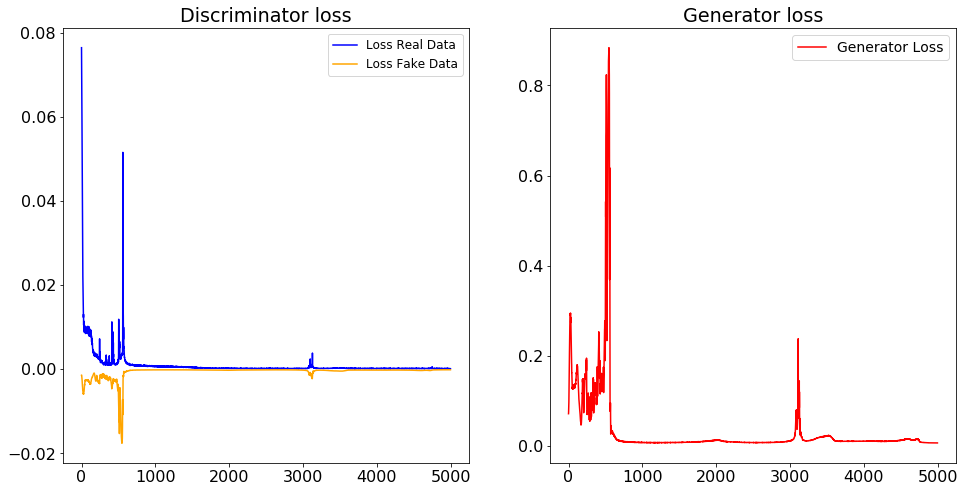

In [10]:
epochs = range(n_epochs)
file_name = "%dcylce" % (n_cycle)
plt.rcParams.update({'font.size': 16})

lossFig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, discriminator_history[:,0], 'b', label='Loss Real Data')
plt.plot(epochs, discriminator_history[:,1], 'orange', label='Loss Fake Data')
plt.title('Discriminator loss')
plt.legend(loc="best", prop={'size': 12})
plt.subplot(1, 2, 2)
plt.plot(epochs, adversarial_history, 'r', label='Generator Loss')
plt.title('Generator loss')
plt.legend(loc="best", prop={'size': 14})
plt.show()

if savePlots:
    lossFig.savefig(plotsLocation + file_name + "Loss.png")

### Distances

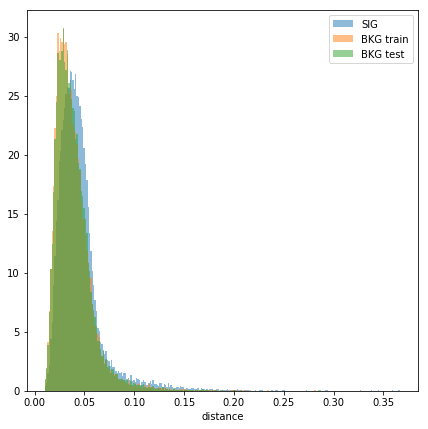

In [16]:
decoded_imgs = autoencoder.predict(sample_test)
decoded_imgs_train = autoencoder.predict(sample_train)

norm_bkg_test=[]
for i in range(sample_test.shape[0]//2):
    norm_bkg_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]
    
norm_sig=[]
for i in range(sample_test.shape[0]//2, sample_test.shape[0]):
    norm_sig += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_bkg_train=[]
for i in range(sample_train.shape[0]):
    norm_bkg_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_sig, bins='auto', alpha=0.5, label='SIG', density=True)
plt.hist(norm_bkg_train, bins, alpha=0.5, label='BKG train', density=True)
plt.hist(norm_bkg_test, bins, alpha=0.5, label='BKG test', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')

if savePlots:
    plt.savefig(plotsLocation + "distances.png")

### ROC

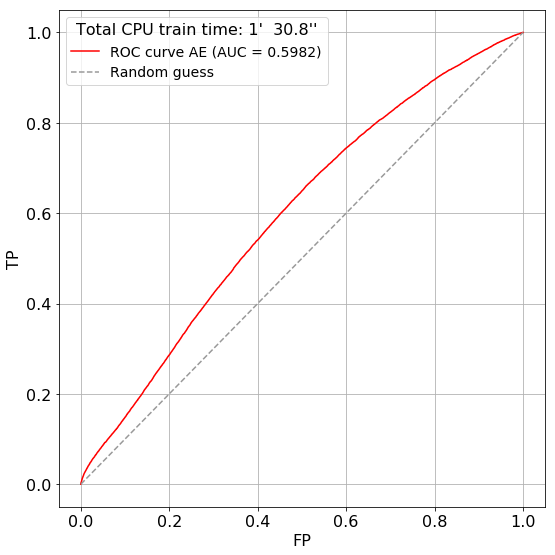

In [14]:
target = np.concatenate((np.zeros(sample_train.shape[0] + n_train),np.ones(n_train)))
scores = np.concatenate((norm_train,norm_test))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(8, 8))
                   
fp, vp, thresholds = roc_curve(target,scores)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
plt.grid()
plt.legend(loc="best", title =time_stamp, prop={'size': 14})
plt.tight_layout()

if savePlots:
    plt.savefig(plotsLocation + file_name + "ROC.png")

### Save Generator

In [ ]:
generator_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(generator_json)

generator.save_weights("generator.h5")

### Encoding Variables Distribution

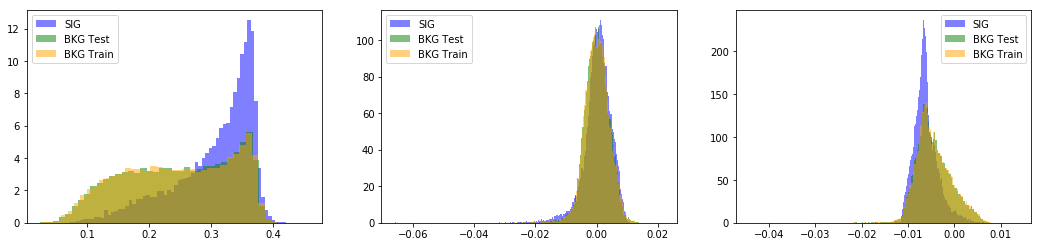

In [15]:
encoded_train = encoder.predict(sample_train)
encoded_bkg = encoder.predict(sample_test[:sample_train.shape[0],])
encoded_sig = encoder.predict(sample_test[sample_train.shape[0]:sample_test.shape[0],])

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(18, 18))
for i in range(encoding_dim):
    plt.subplot(4, 3, i+1)
    n, bins, patches=plt.hist(encoded_sig[:,i], bins='auto', alpha=0.5, label='SIG', color='blue', density=True)
    n, bins, patches=plt.hist(encoded_bkg[:,i], bins='auto', alpha=0.5, label='BKG Test', color='green',  density=True)
    n, bins, patches=plt.hist(encoded_train[:,i], bins='auto', alpha=0.5, label='BKG Train', color='orange', density=True)
    plt.legend(loc='best')
plt.show()

### Reconstruction Visualizations

##### Bakground from training

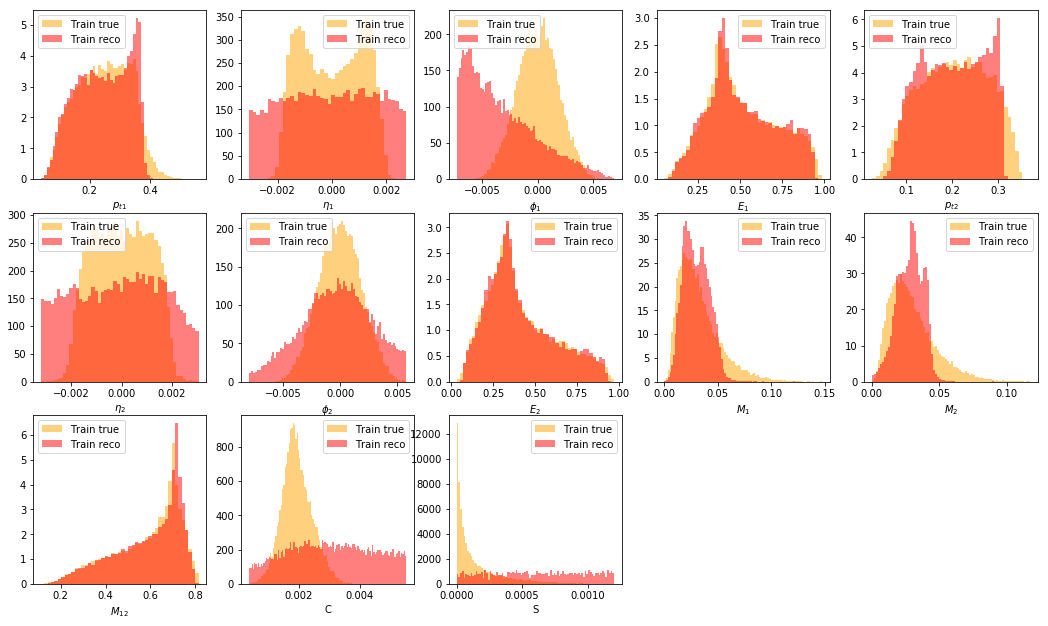

In [18]:
plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 10})
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches=plt.hist(sample_train[:,i], bins='auto', alpha=0.5, label='Train true',color='orange', density=True)
    plt.hist(decoded_imgs_train[:,i], bins=bins, alpha=0.5, label='Train reco',color='red' , density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')

##### Background not seen

In [3]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[:sample_test.shape[0]//2,i], bins='auto', alpha=0.5, label='Test bkg true', color='green', density=True)
    n, bins, patches = plt.hist(decoded_imgs[:sample_test.shape[0]//2,i], bins, alpha=0.5, label='Test bkg reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')
plt.savefig(plotsLocation + "Reco.png")
    

NameError: name 'sample_train' is not defined

<Figure size 1296x1296 with 0 Axes>

##### Signal

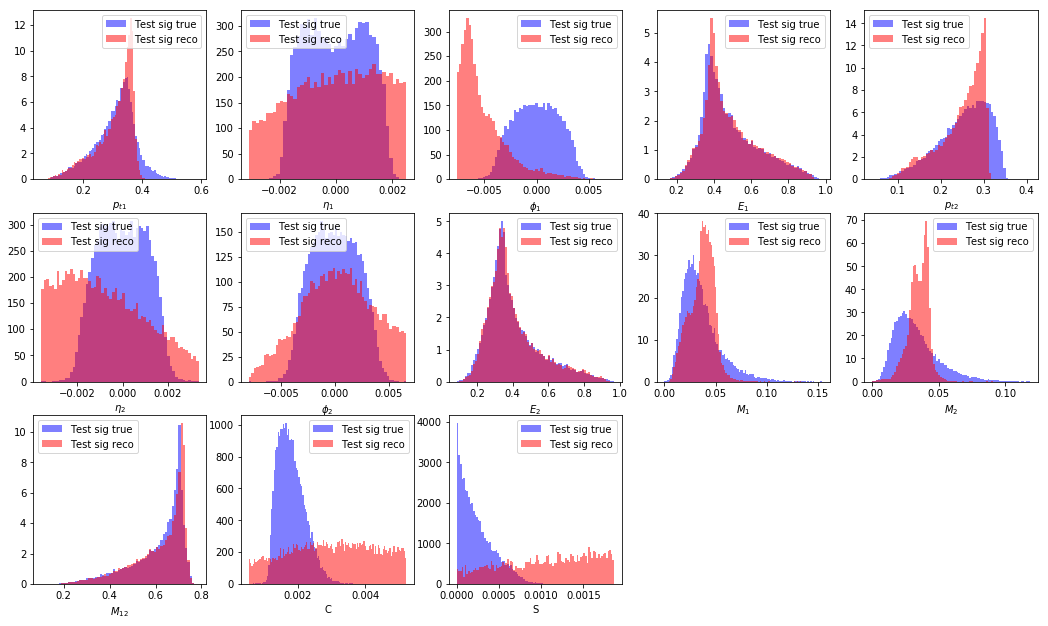

In [21]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[sample_test.shape[0]//2:sample_test.shape[0],i], bins='auto', alpha=0.5, label='Test sig true', color='blue', density=True)
    n, bins, patches = plt.hist(decoded_imgs[sample_test.shape[0]//2:sample_test.shape[0],i], bins, alpha=0.5, label='Test sig reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')

### Generated Data

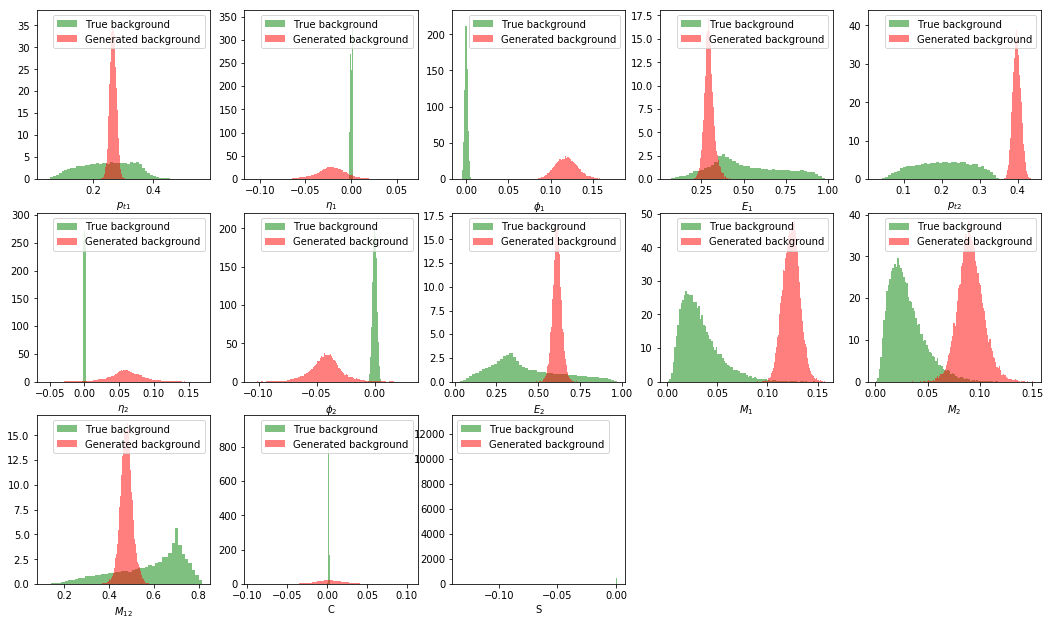

In [23]:
noise = np.random.uniform(0, 1.0, size=[n_train, input_dim])
data_fake = generator.predict(noise)

plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches=plt.hist(sample_train[:,i], bins='auto', alpha=0.5, label='True background',color='green', density=True)
    plt.hist(data_fake[:,i], bins='auto', alpha=0.5, label='Generated background',color='red' , density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')